This tutorial will be focused on computing the maximum cross-correlation...

TODO:
- Extract parameters of best cross-correlation, both for translations and for the grid of parameters
- Plot simulated vs. observed images
- Further optimize with gradient descent
- Write STAR file of results
- Formalize tutorial

In [1]:
import equinox as eqx

In [2]:
# Plotting imports and function definitions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

In [3]:
import cryojax.simulator as cxs
from cryojax.data import read_array_with_spacing_from_mrc


# Instantiate the scattering potential
filename = "./data/ribosome_4ug0_scattering_potential_from_cistem.mrc"
real_voxel_grid, voxel_size = read_array_with_spacing_from_mrc(filename)
potential = cxs.FourierVoxelGridPotential.from_real_voxel_grid(
    real_voxel_grid, voxel_size, pad_scale=1.5
)

In [33]:
# Read dataset and extract normalized particle stack
import jax

from cryojax.data import RelionDataset
from cryojax.image import normalize_image, rfftn


@jax.vmap
def normalize_image_stack(image):
    return normalize_image(image, is_real=True)


make_config_fn = lambda shape, pixel_size: cxs.ImageConfig(
    shape, pixel_size, padded_shape=potential.shape[0:2]
)
dataset = RelionDataset(
    path_to_starfile="./data/ribosome_4ug0_particles.star",
    path_to_relion_project="./",
)

particle_stack = dataset[:3]
fourier_image_stack = rfftn(
    normalize_image_stack(particle_stack.image_stack), axes=(1, 2)
)

In [48]:
from functools import partial

import equinox.internal as eqxi
import jax

from cryojax.rotations import SO3


@partial(eqx.filter_vmap, out_axes=eqxi.if_mapped(axis=0))
def make_pose_grid(key):
    return cxs.QuaternionPose.from_rotation(SO3.sample_uniform(key))


number_of_poses = 100_000
keys = jax.random.split(jax.random.PRNGKey(0), number_of_poses)
pose_grid = make_pose_grid(keys)

In [49]:
# Build cryojax specimen
# ... now instantiate fourier slice extraction
integrator = cxs.FourierSliceExtract(interpolation_order=1)
# ... now, build the biological specimen
specimen = cxs.Specimen(potential, integrator, pose_grid)

In [50]:
# Make the instrument from the particle stack
import cryojax as cx


@partial(eqx.filter_vmap, in_axes=(0, None), out_axes=eqxi.if_mapped(axis=0))
def make_optics(vmap, no_vmap):
    ctf = eqx.combine(vmap, no_vmap)
    return cxs.WeakPhaseOptics(ctf)


ctf_filter_spec = cx.get_filter_spec(
    particle_stack.ctf,
    lambda x: (
        x.defocus_u_in_angstroms,
        x.defocus_v_in_angstroms,
        x.astigmatism_angle,
        x.phase_shift,
    ),
)
per_particle_ctf, optics_group_ctf = eqx.partition(particle_stack.ctf, ctf_filter_spec)
optics = make_optics(per_particle_ctf, optics_group_ctf)
instrument = cxs.Instrument(
    voltage_in_kilovolts=particle_stack.ctf.voltage_in_kilovolts, optics=optics
)

pipeline = cxs.ImagePipeline(
    config=particle_stack.config, specimen=specimen, instrument=instrument
)

In [51]:
from cryojax.image import irfftn


per_particle_filter_spec = cx.get_filter_spec(
    pipeline,
    lambda p: (
        p.instrument.optics.ctf.defocus_u_in_angstroms,
        p.instrument.optics.ctf.defocus_v_in_angstroms,
        p.instrument.optics.ctf.astigmatism_angle,
        p.instrument.optics.ctf.phase_shift,
    ),
)


@partial(cx.filter_vmap_with_spec, filter_spec=per_particle_filter_spec, in_axes=(0, 0))
def cross_correlation(pipeline, fourier_observed_image):
    fourier_simulated_image = pipeline.render(get_real=False, normalize=True)
    return (
        irfftn(
            fourier_observed_image * fourier_simulated_image, s=pipeline.config.shape
        )
        / pipeline.config.n_pix
    )


@eqx.filter_jit
def objective_function(pipeline_at_grid_point, args):
    (
        pipeline_not_at_grid_point_vmap,
        pipeline_not_at_grid_point_no_vmap,
        fourier_observed_image_stack,
    ) = args
    pipeline_not_at_grid_point = eqx.combine(
        pipeline_not_at_grid_point_vmap, pipeline_not_at_grid_point_no_vmap
    )
    pipeline = eqx.combine(pipeline_at_grid_point, pipeline_not_at_grid_point)

    return -cross_correlation(pipeline, fourier_observed_image_stack)


@partial(eqx.filter_vmap, in_axes=(None, (0, None)))
def simulate_fourier_image_stack(pipeline_at_grid_point, args):
    pipeline_not_at_grid_point_vmap, pipeline_not_at_grid_point_no_vmap = args
    pipeline_not_at_grid_point = eqx.combine(
        pipeline_not_at_grid_point_vmap, pipeline_not_at_grid_point_no_vmap
    )
    pipeline = eqx.combine(pipeline_at_grid_point, pipeline_not_at_grid_point)

    return pipeline.render(get_real=False, normalize=True)

In [52]:
from cryojax.inference import tree_grid_take, tree_grid_unravel_index


tree_grid_filter_spec = cx.get_filter_spec(pipeline, lambda p: p.specimen.pose.wxyz)

pipeline_tree_grid, pipeline_non_tree_grid = eqx.partition(
    pipeline, tree_grid_filter_spec
)
per_particle_pipeline, non_per_particle_pipeline = eqx.partition(
    pipeline_non_tree_grid, per_particle_filter_spec
)

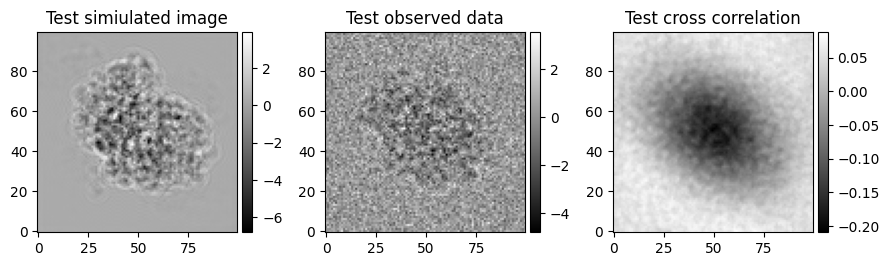

In [53]:
test_pipeline_grid_point = tree_grid_take(
    pipeline_tree_grid, tree_grid_unravel_index(0, pipeline_tree_grid)
)
test_simulated_fourier_image_stack = simulate_fourier_image_stack(
    test_pipeline_grid_point, (per_particle_pipeline, non_per_particle_pipeline)
)
neg_cc = objective_function(
    test_pipeline_grid_point,
    (per_particle_pipeline, non_per_particle_pipeline, fourier_image_stack),
)
fig, axes = plt.subplots(figsize=(9, 3.5), ncols=3)
plot_image(
    irfftn(test_simulated_fourier_image_stack[0], s=pipeline.config.shape),
    fig,
    axes[0],
    label="Test simiulated image",
)
plot_image(
    irfftn(fourier_image_stack[0], s=pipeline.config.shape),
    fig,
    axes[1],
    label="Test observed data",
)
plot_image(
    neg_cc[0],
    fig,
    axes[2],
    label="Test cross correlation",
)
plt.tight_layout()

In [54]:
import math

from cryojax.inference import MinimumSearchMethod, run_grid_search, tree_grid_shape


method = MinimumSearchMethod(batch_size=100)
n_iterations = math.prod(tree_grid_shape(pipeline_tree_grid)) // method.batch_size
result = run_grid_search(
    objective_function,
    method,
    pipeline_tree_grid,
    args=(per_particle_pipeline, non_per_particle_pipeline, fourier_image_stack),
    progress_bar=True,
    print_every=n_iterations // 10,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

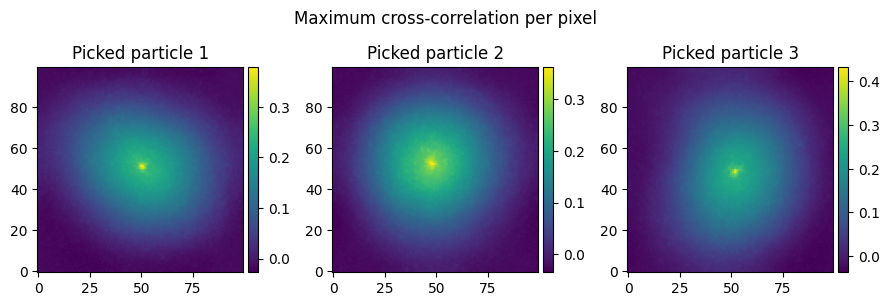

In [55]:
n_images = particle_stack.image_stack.shape[0]
fig, axes = plt.subplots(figsize=(3 * n_images, 3), ncols=n_images)
fig.suptitle("Maximum cross-correlation per pixel")
[
    plot_image(
        -result.state.current_minimum_eval[i],
        fig,
        axes[i],
        cmap="viridis",
        label=f"Picked particle {i+1}",
    )
    for i in range(n_images)
]
plt.tight_layout()